In [7]:
import os
os.chdir('..')
os.getcwd()

'/home/david/git/dalbandea/phd/codes/3-Phi4/pyScalar2D'

In [8]:
%load_ext autoreload
%autoreload 2

In [9]:
import numpy as np
from network import *
from network.networks import *
from network.training import *

import matplotlib.pyplot as plt

print(f"TORCH DEVICE: {torch_device}")

TORCH VERSION: 1.9.0+cu102
TORCH DEVICE: cpu


## Load function from name

In [14]:
loss_fn = globals()["calc_dkl"]

In [15]:
loss_fn.__name__

'calc_dkl'

In [9]:
calc_dkl.__name__

'calc_dkl'

## Plotting utilities

In [4]:
from IPython.display import display

def init_live_plot(dpi=125, figsize=(8,4)):
    fig, ax_ess = plt.subplots(1,1, dpi=dpi, figsize=figsize)
    plt.xlim(0, N_era*N_epoch)
    plt.ylim(0, 1)
    
    ess_line = plt.plot([0],[0], alpha=0.5) # dummy
    plt.grid(False)
    plt.ylabel('ESS')
    
    ax_loss = ax_ess.twinx()
    loss_line = plt.plot([0],[0], alpha=0.5, c='orange') # dummy
    plt.grid(False)
    plt.ylabel('Loss')
    
    plt.xlabel('Epoch')

    display_id = display(fig, display_id=True)

    return dict(
        fig=fig, ax_ess=ax_ess, ax_loss=ax_loss,
        ess_line=ess_line, loss_line=loss_line,
        display_id=display_id
    )

def moving_average(x, window=10):
    if len(x) < window:
        return np.mean(x, keepdims=True)
    else:
        return np.convolve(x, np.ones(window), 'valid') / window

def update_plots(history, fig, ax_ess, ax_loss, ess_line, loss_line, display_id):
    Y = np.array(history['ess'])
    Y = moving_average(Y, window=15)
    ess_line[0].set_ydata(Y)
    ess_line[0].set_xdata(np.arange(len(Y)))
    Y = history['loss']
    Y = moving_average(Y, window=15)
    loss_line[0].set_ydata(np.array(Y))
    loss_line[0].set_xdata(np.arange(len(Y)))
    ax_loss.relim()
    ax_loss.autoscale_view()
    fig.canvas.draw()
    display_id.update(fig) # need to force colab to update plot

## $m_0$-$\lambda$ parametrization

In [5]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
M2 = -4.0
lam = 8.0
phi4_action = ScalarPhi4Action(M2=M2, lam=lam)

# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape,
        n_layers=n_layers, hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

In [6]:
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

# Main training setup and loop
N_era = 4
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

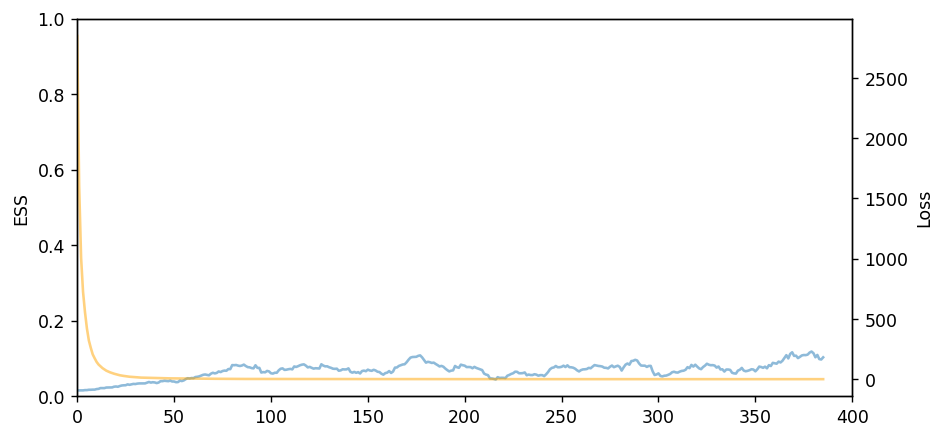

== Era 0 | Epoch 0 metrics ==
	loss 18853.2
	logp -18963.3
	logq -110.071
	ess 0.015625
== Era 1 | Epoch 0 metrics ==
	loss 253.531
	logp -288.232
	logq -34.7008
	ess 0.043136
== Era 2 | Epoch 0 metrics ==
	loss 0.285804
	logp -18.7756
	logq -18.4898
	ess 0.0756493
== Era 3 | Epoch 0 metrics ==
	loss -0.483821
	logp -15.9685
	logq -16.4523
	ess 0.071414


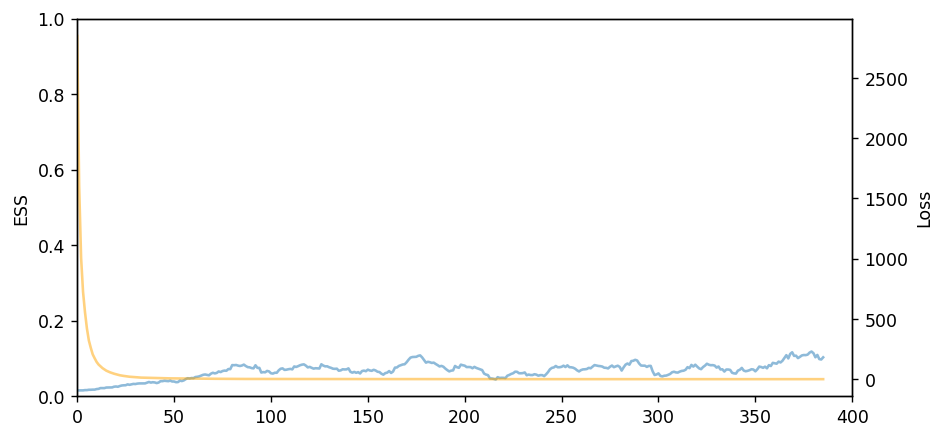

In [7]:
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()

# Main loop
for era in range(N_era):
    for epoch in range(N_epoch):
        train_step(model, phi4_action, calc_dkl, optimizer, history, batch_size=batch_size)
        
        if epoch % print_freq == 0:
            print_metrics(history, avg_last_N_epochs=print_freq, era=era, epoch=epoch)
            
        if epoch % plot_freq == 0:
            update_plots(history, **live_plot)

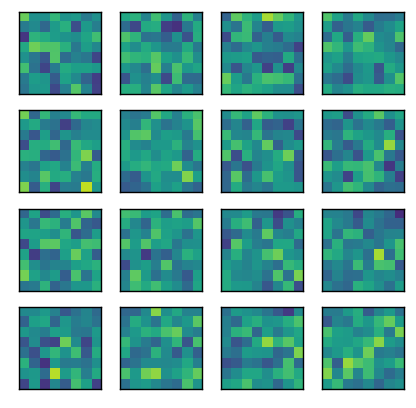

In [51]:
# Evaluate the model
torch_x, torch_logq = apply_flow_to_prior(prior, model['layers'], batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()


## $\beta$-$\lambda$ parametrization

In [10]:
# Lattice Theory
L = 8
lattice_shape = (L,L)
beta = np.sqrt(1.0/16.0)
lam = 0.5
phi4_action = ScalarPhi4ActionBeta(beta=beta, lam=lam)


# Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
n_layers = 16
hidden_sizes = [8,8]
kernel_size = 3
layers = make_phi4_affine_layers(lattice_shape=lattice_shape,
        n_layers=n_layers, hidden_sizes=hidden_sizes, kernel_size=kernel_size)
model = {'layers': layers, 'prior': prior}

In [11]:
# Training
base_lr = .001
optimizer = torch.optim.Adam(model['layers'].parameters(), lr=base_lr)

# Main training setup and loop
N_era = 4
N_epoch = 100
batch_size = 64
print_freq = N_epoch
plot_freq = 1

history = {
    'loss' : [],
    'logp' : [],
    'logq' : [],
    'ess' : []
}

In [64]:
len(history['logq'])

800

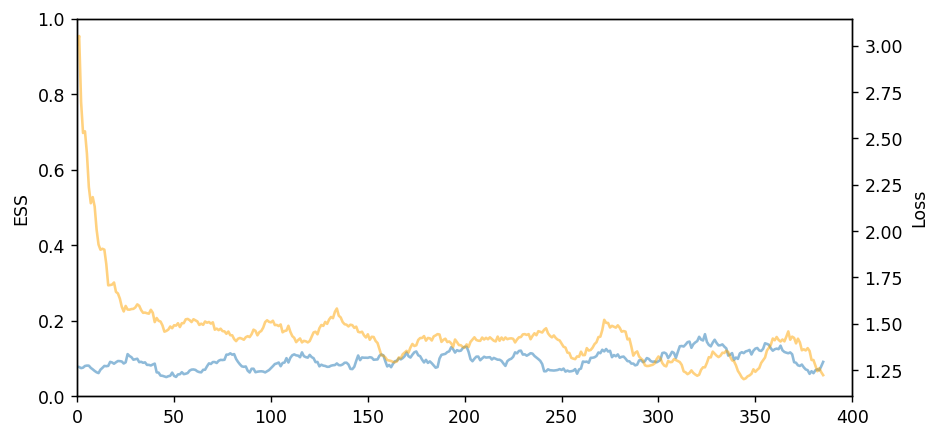

== Era 0 | Epoch 0 metrics ==
	loss 2.3893
	logp -13.8109
	logq -15.8979
	ess 0.0657781
== Era 1 | Epoch 0 metrics ==
	loss 1.76204
	logp -14.1452
	logq -14.3256
	ess 0.0787044
== Era 2 | Epoch 0 metrics ==
	loss 1.43717
	logp -14.8308
	logq -15.0339
	ess 0.0916727
== Era 3 | Epoch 0 metrics ==
	loss 1.40542
	logp -15.1172
	logq -15.2973
	ess 0.100028


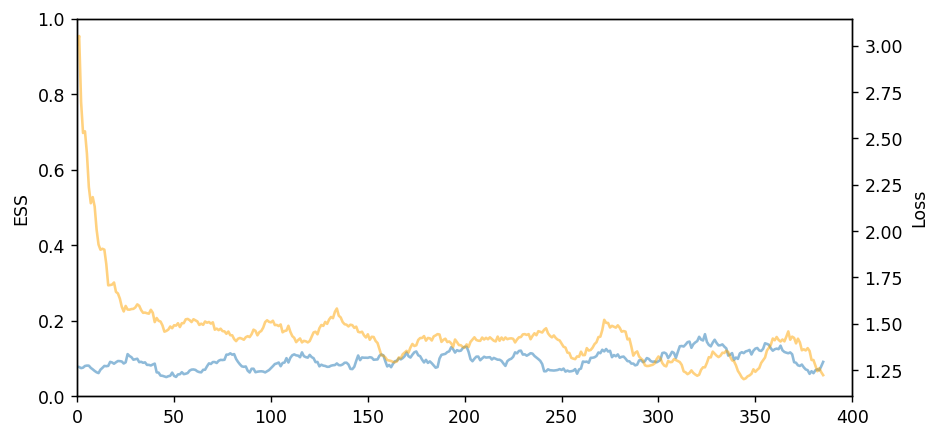

In [9]:
[plt.close(plt.figure(fignum)) for fignum in plt.get_fignums()] # close all existing figures
live_plot = init_live_plot()

# Main loop
for era in range(N_era):
    for epoch in range(N_epoch):
        train_step(model, phi4_action, calc_dkl, optimizer, history, batch_size=batch_size)
        
        if epoch % print_freq == 0:
            print_metrics(history, avg_last_N_epochs=print_freq, era=era, epoch=epoch)
            
        if epoch % plot_freq == 0:
            update_plots(history, **live_plot)

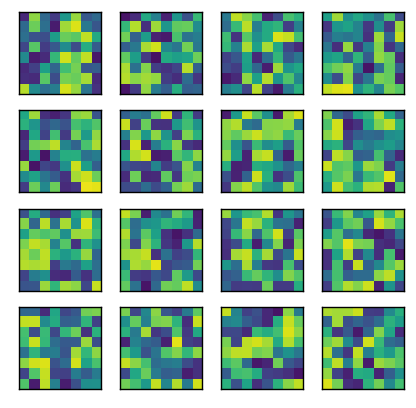

In [8]:
# Evaluate the model
torch_x, torch_logq = apply_flow_to_prior(prior, model['layers'], batch_size=1024)
x = grab(torch_x)

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(x[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()


z.shape = (1024, 8, 8)


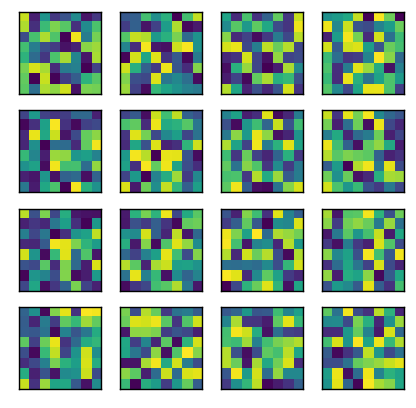

In [15]:
# Compare with uncorrelated prior
torch_z = prior.sample_n(1024)
z = grab(torch_z)
print(f'z.shape = {z.shape}')

fig, ax = plt.subplots(4,4, dpi=125, figsize=(4,4))
for i in range(4):
    for j in range(4):
        ind = i*4 + j
        ax[i,j].imshow(np.tanh(z[ind]), vmin=-1, vmax=1, cmap='viridis')
        ax[i,j].axes.xaxis.set_visible(False)
        ax[i,j].axes.yaxis.set_visible(False)
plt.show()

In [57]:
min(S_eff)

55.1518887000663

slope 1 linear regression S = S_eff + -49.9250


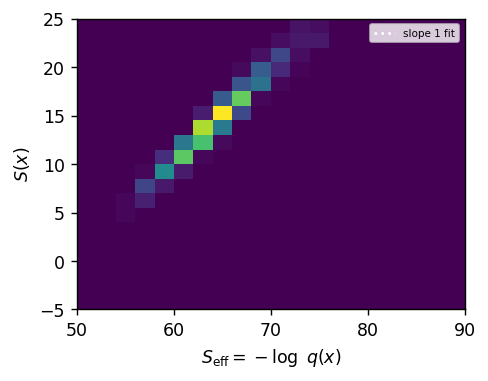

In [9]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
fit_b = np.mean(S) - np.mean(S_eff)
print(f'slope 1 linear regression S = S_eff + {fit_b:.4f}')
fig, ax = plt.subplots(1,1, dpi=125, figsize=(4,4))
ax.hist2d(S_eff, S, bins=20, range=[[50, 90], [-5, 25]])
ax.set_xlabel(r'$S_{\mathrm{eff}} = -\log~q(x)$')
ax.set_ylabel(r'$S(x)$')
ax.set_aspect('equal')
xs = np.linspace(5, 35, num=4, endpoint=True)
ax.plot(xs, xs + fit_b, ':', color='w', label='slope 1 fit')
plt.legend(prop={'size': 6})
plt.show()


In [13]:
def serial_sample_generator(model, action, batch_size, N_samples):
    layers, prior = model['layers'], model['prior']
    layers.eval()
    x, logq, logp = None, None, None
    for i in range(N_samples):
        batch_i = i % batch_size
        if batch_i == 0:
            # we're out of samples to propose, generate a new batch
            x, logq = apply_flow_to_prior(prior, layers, batch_size=batch_size)
            logp = -action(x)
        yield x[batch_i], logq[batch_i], logp[batch_i]

Now we need to iterate over the samples and construct them into a Markov Chain. The code below implements the Metropolis independence sampler to do this.

In [14]:
def make_mcmc_ensemble(model, action, batch_size, N_samples):
    history = {
        'x' : [],
        'logq' : [],
        'logp' : [],
        'accepted' : []
    }

    # build Markov chain
    sample_gen = serial_sample_generator(model, action, batch_size, N_samples)
    for new_x, new_logq, new_logp in sample_gen:
        if len(history['logp']) == 0:
            # always accept first proposal, Markov chain must start somewhere
            accepted = True
        else: 
            # Metropolis acceptance condition
            last_logp = history['logp'][-1]
            last_logq = history['logq'][-1]
            p_accept = torch.exp((new_logp - new_logq) - (last_logp - last_logq))
            p_accept = min(1, p_accept)
            draw = torch.rand(1) # ~ [0,1]
            if draw < p_accept:
                accepted = True
            else:
                accepted = False
                new_x = history['x'][-1]
                new_logp = last_logp
                new_logq = last_logq
        # Update Markov chain
        history['logp'].append(new_logp)
        history['logq'].append(new_logq)
        history['x'].append(new_x)
        history['accepted'].append(accepted)
    return history

Finally, the cell below uses the code above to generate an ensemble of configurations using our trained flow model. You should see a 30-40% accept rate.

In [25]:
ensemble_size = 1000
phi4_ens = make_mcmc_ensemble(model, phi4_action, 64, ensemble_size)
print("Accept rate:", np.mean(phi4_ens['accepted']), "+/-", np.std(phi4_ens['accepted'])/np.sqrt(ensemble_size))

Accept rate: 0.647 +/- 0.015112610628213776


## Save and Load Model

In [41]:
try:
    save_filename = "L"+str(L)+"_b"+str(phi4_action.beta)+"_l"+str(lam)+"_E"+str(N_epoch*N_era)+"_B"+str(batch_size)+"_LOSS"+loss_fn.__name__.replace("_","")
except:
    save_filename = "L"+str(L)+"_b"+str(phi4_action.m2)+"_l"+str(lam)+"_E"+str(N_epoch*N_era)+"_B"+str(batch_size)+"_LOSS"+loss_fn.__name__.replace("_","")

In [42]:
save_filename

'L8_b0.25_l0.5_E400_B64_LOSScalcdkl'

In [44]:
def save_model(filename, model, history):
    torch.save(model['layers'].state_dict(), filename+"_model.pth")
    
    loss = [i.item() for i in history['loss']]
    ess  = [i.item() for i in history['ess']]
    logq = [i.mean() for i in history['logq']]
    logp = [i.mean() for i in history['logp']]
    
    hist = np.transpose(np.vstack((loss, ess, logq, logp)))
    np.savetxt(filename+"_history.txt", hist)

In [83]:
save_model("./"+savedir, model, history)

In [6]:
def load_model(path, layers):
    layers.load_state_dict(torch.load(path))

In [12]:
load_model("L8_b0.25_l0.5_E1000_B500_LOSSdkl_model.pth", model['layers'])

In [45]:
model

{'layers': ModuleList(
   (0): AffineCoupling(
     (net): Sequential(
       (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (1): LeakyReLU(negative_slope=0.01)
       (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (3): LeakyReLU(negative_slope=0.01)
       (4): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (5): Tanh()
     )
   )
   (1): AffineCoupling(
     (net): Sequential(
       (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (1): LeakyReLU(negative_slope=0.01)
       (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (3): LeakyReLU(negative_slope=0.01)
       (4): Conv2d(8, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=circular)
       (5): Tanh()
     )
   )
   (2): AffineCoupling(
     (net): Sequential(
     